In [1]:
import os
import qiime2
import biom
import pandas as pd
import seaborn as sns
from qiime2.plugins import feature_table
from qiime2.plugins import taxa
import matplotlib.pyplot as plt

from q2_quality_control._evaluate_taxonomy import _evaluate_taxonomy
from q2_quality_control._utilities import (
    _evaluate_composition, _compute_per_level_accuracy, _match_samples_by_index, _drop_nans_zeros)

%matplotlib inline


In [2]:
def _calc_prf(exp_taxa, obs_taxa, table, prf_results):
    # calculate weighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=table,
        sample_id=None)
    prf['sample'] = sample
    prf['fold'] = fold
    prf['method'] = 'weighted'
    prf_results = pd.concat([prf_results, prf])

    # calculate unweighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=None,
        sample_id=None)
    prf['sample'] = sample
    prf['fold'] = fold
    prf['method'] = 'unweighted'
    prf_results = pd.concat([prf_results, prf])
    
    return prf_results


def _collapse_frequency_table_to_relative_frequency(table, taxonomy, level=7):
    try:
        table_l7 = taxa.methods.collapse(table=table, level=level, taxonomy=taxonomy)
    # occasionally only genus-level classifications may be present, so let's collapse there
    except ValueError:
        table_l7 = taxa.methods.collapse(table=table, level=level-1, taxonomy=taxonomy)
    rel_freq = feature_table.methods.relative_frequency(table_l7.collapsed_table)
    obs_table = rel_freq.relative_frequency_table.view(pd.DataFrame)
    return obs_table


def _eval_comp_basic(exp, obs, depth=7):
    exp, obs = _match_samples_by_index(exp, obs)

    # DROP NANS/ZERO ABUNDANCE FEATURES
    obs = _drop_nans_zeros(obs)
    exp = _drop_nans_zeros(exp)

    # TAR/TDR for obs vs. exp at each level
    try:
        results, vectors = _compute_per_level_accuracy(exp, obs, metadata=None, depth=depth)
    # occasionally only genus-level classifications may be present, so let's collapse there
    except ValueError:
        results, vectors = _compute_per_level_accuracy(exp, obs, metadata=None, depth=depth-1)
    return results



In [3]:
project_dir = os.path.expandvars('.')
sample_types = ['vaginal', 'soil', 'tears', 'rhizosphere-100nt']
class_weights = ['bespoke92', 'uniform92', 'bespoke70', 'uniform70']


# Evaluate taxa

In [8]:
#prf_results = pd.DataFrame()
#eval_comp_results = pd.DataFrame()
eval_comp_results = pd.read_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
prf_results = pd.read_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')

for sample_type in sample_types:
    type_results = pd.DataFrame()
    type_dir = os.path.join(project_dir, sample_type)
    eval_taxa_dir = os.path.join(type_dir, 'eval_taxa')
    eval_comp_dir = os.path.join(type_dir, 'eval_comp')
    if not os.path.exists(eval_taxa_dir):
        os.makedirs(eval_taxa_dir)
    expected_dir = os.path.join(type_dir, 'expected')
    fns = os.listdir(expected_dir)
    frequencies_dir = os.path.join(type_dir, 'frequencies')
    relative_frequencies_dir = os.path.join(type_dir, 'relative_frequencies')
    if not os.path.exists(relative_frequencies_dir):
        os.makedirs(relative_frequencies_dir)
    for cw in class_weights:
        cw_dir = os.path.join(type_dir, cw)
        et_dir = os.path.join(eval_taxa_dir, cw)
        ec_dir = os.path.join(eval_comp_dir, cw)
        cw_results = pd.DataFrame()
        
        # evaluate taxonomy
        for fn in fns:
            if fn in ['log', 'log_missed']:
                continue
            sn, _ = os.path.splitext(fn)
            #sample, fold = sn.split('-fold-')
            sample, fold = sn, 1

            # convert table to relative frequencies
            rel_freq_fp = os.path.join(relative_frequencies_dir, fn)
            if not os.path.exists(rel_freq_fp):
                table_fp = os.path.join(frequencies_dir, fn)
                table = qiime2.Artifact.load(table_fp)
                rel_freq = feature_table.methods.relative_frequency(table)
                rel_freq.relative_frequency_table.save(rel_freq_fp)
                table = rel_freq.relative_frequency_table.view(biom.Table)
            else:
                table = qiime2.Artifact.load(rel_freq_fp).view(biom.Table)

            # load data
            exp_taxa_fp = os.path.join(expected_dir, fn)
            exp_taxa = qiime2.Artifact.load(exp_taxa_fp).view(pd.Series)
            obs_taxa_fp = os.path.join(cw_dir, fn)
            obs_taxa = qiime2.Artifact.load(obs_taxa_fp).view(pd.Series)

            cw_results = _calc_prf(exp_taxa, obs_taxa, table, cw_results)
            
            # evaluate composition
            table_fp = os.path.join(frequencies_dir, fn)
            table = qiime2.Artifact.load(table_fp)
            exp_table = _collapse_frequency_table_to_relative_frequency(
                table, qiime2.Artifact.load(exp_taxa_fp))
            obs_table = _collapse_frequency_table_to_relative_frequency(
                table, qiime2.Artifact.load(obs_taxa_fp))

            results = _eval_comp_basic(exp_table, obs_table)
            results['class weights'] = cw
            results['sample type'] = sample_type

            eval_comp_results = pd.concat([eval_comp_results, results])
            
        cw_results['class weights'] = cw
        type_results = pd.concat([type_results, cw_results])
            
        # evaluate composition
        
    type_results['sample type'] = sample_type
    prf_results = pd.concat([prf_results, type_results])


/Users/nbokulich/Desktop/projects/q2-quality-control/q2_quality_control/_utilities.py:174: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  obs_collapsed.loc[sample]], axis=1).fillna(0)
/Users/nbokulich/miniconda3/envs/qiime2-2018.4.0.dev/lib/python3.5/site-packages/ipykernel_launcher.py:64: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

/Users/nbokulich/miniconda3/envs/qiime2-2018.4.0.dev/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/nbokulich/miniconda3/envs/qi

In [9]:
eval_comp_results.to_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')

In [10]:
prf_results.to_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')


In [11]:
l7 = prf_results[(prf_results['level'] == 7) & (prf_results['method'] == 'weighted')]


In [12]:
palette = "Set1"


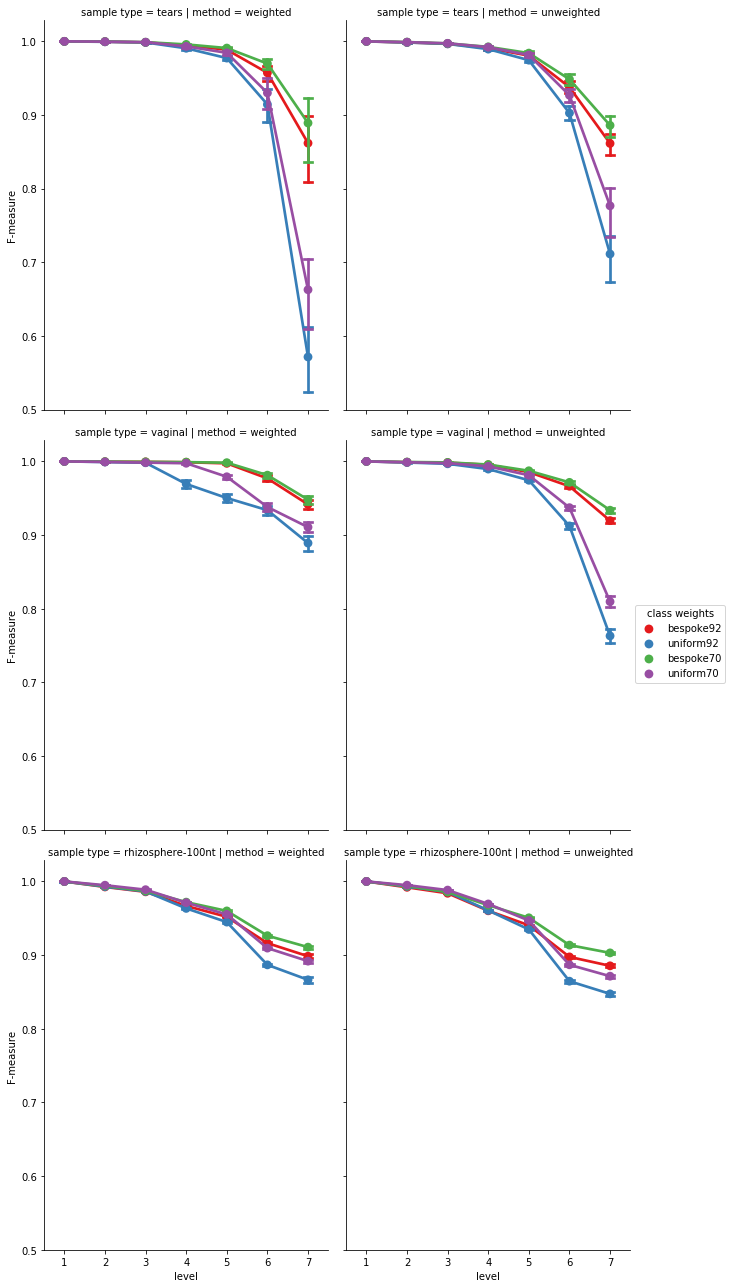

In [13]:
g = sns.factorplot(x="level", y="F-measure", hue="class weights", col="method", row="sample type", data=prf_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


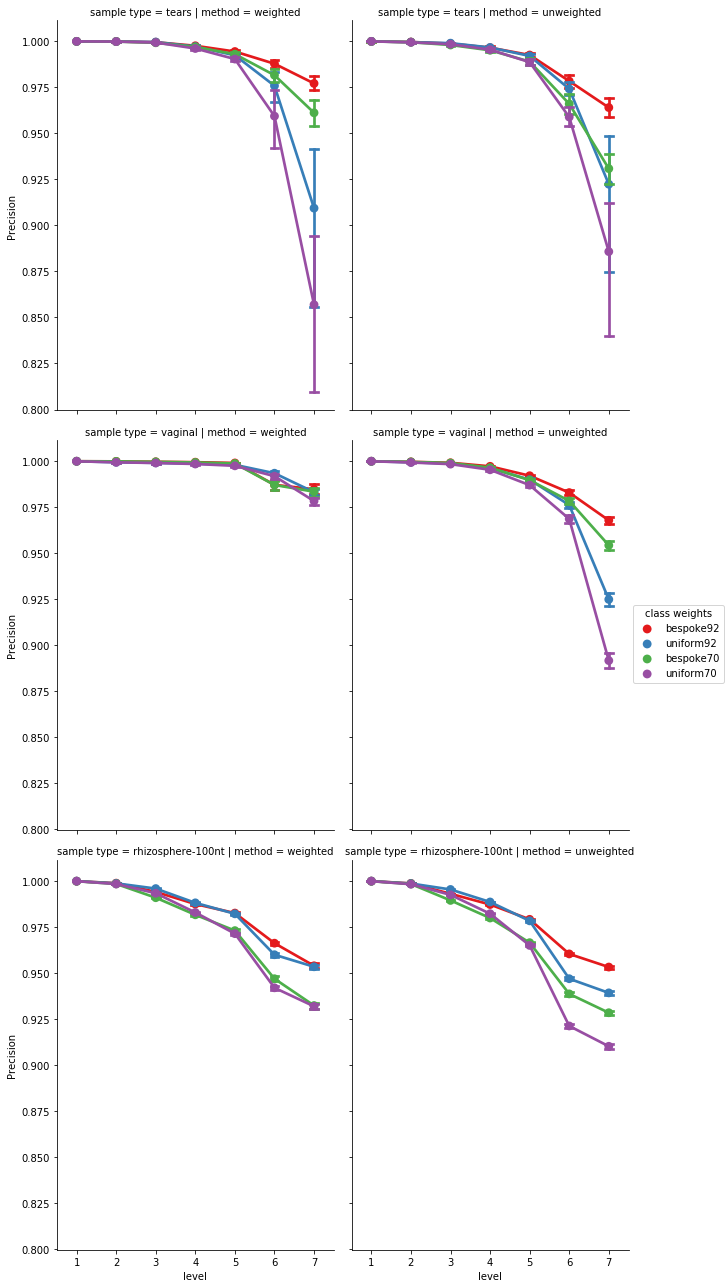

In [14]:
g = sns.factorplot(x="level", y="Precision", hue="class weights", col="method", row="sample type", data=prf_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


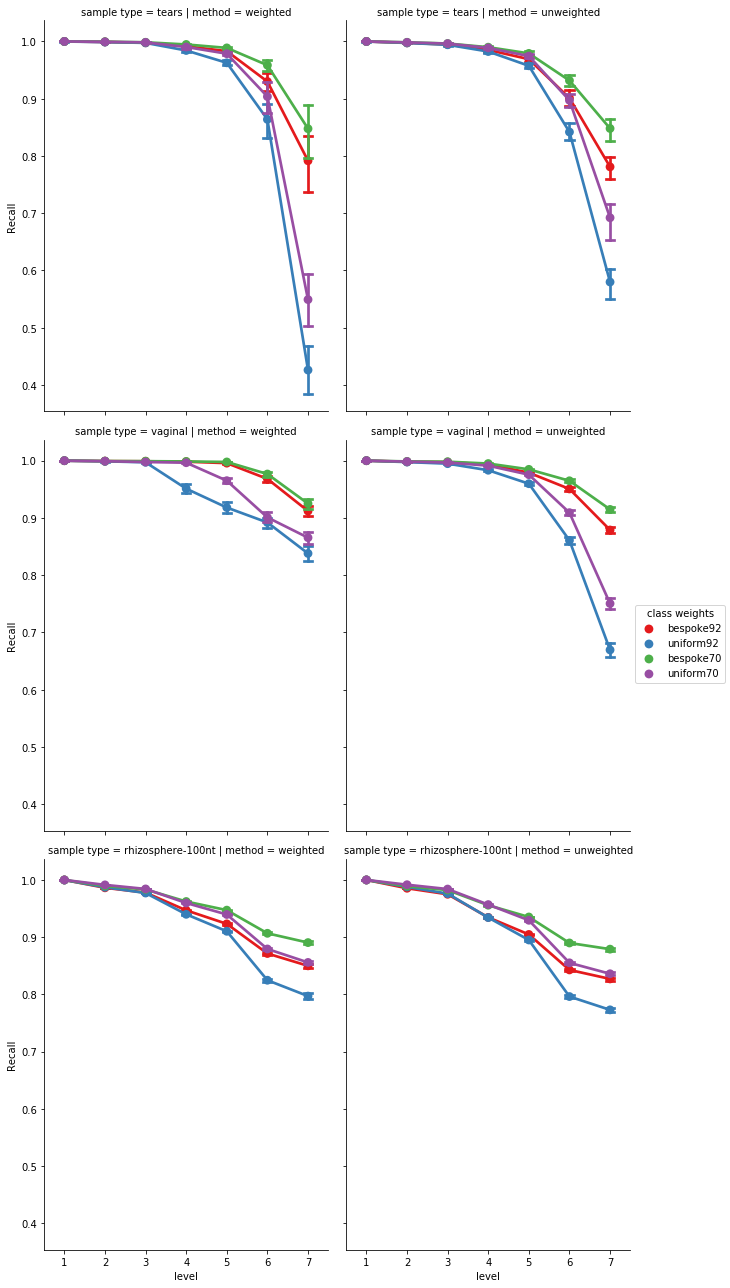

In [15]:
g = sns.factorplot(x="level", y="Recall", hue="class weights", col="method", row="sample type", data=prf_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


# Evaluate composition

In [16]:
eval_comp_results


,Bray-Curtis,Intercept,Jaccard,Observed / Expected Taxa,Observed Taxa,P value,Slope,Std Err,TAR,TDR,Unnamed: 0,Unnamed: 0.1,class weights,level,r-squared,r-value,sample,sample type
0,0.000000e+00,NaN,0.000000,1.000000,1,NaN,NaN,NaN,1.000000,1.000000,0.0,0.0,bespoke92,1,0.000000,0.000000,Frequency,tears
1,0.000000e+00,0.000000e+00,0.000000,1.000000,2,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.0,1.0,bespoke92,2,1.000000,1.000000,Frequency,tears
2,0.000000e+00,0.000000e+00,0.000000,1.000000,2,0.000000e+00,1.000000,0.000000,1.000000,1.000000,2.0,2.0,bespoke92,3,1.000000,1.000000,Frequency,tears
3,0.000000e+00,0.000000e+00,0.000000,1.000000,2,0.000000e+00,1.000000,0.000000,1.000000,1.000000,3.0,3.0,bespoke92,4,1.000000,1.000000,Frequency,tears
4,0.000000e+00,0.000000e+00,0.000000,1.000000,2,0.000000e+00,1.000000,0.000000,1.000000,1.000000,4.0,4.0,bespoke92,5,1.000000,1.000000,Frequency,tears
5,0.000000e+00,0.000000e+00,0.000000,1.000000,2,0.000000e+00,1.000000,0.000000,1.000000,1.000000,5.0,5.0,bespoke92,6,1.000000,1.000000,Frequency,tears
6,9.838710e-01,5.081945e-01,0.666667,1.000000,2,6.484422e-01,-0.524583,0.851359,0.500000,0.500000,6.0,6.0,bespoke92,7,0.275188,-0.524583,Frequency,tears
7,2.220446e-16,NaN,0.000000,1.000000,1,NaN,NaN,NaN,1.000000,1.000000,7.0,0.0,bespoke92,1,0.000000,0.000000,Frequency,tears
8,1.392116e-16,2.775558e-17,0.000000,1.000000,7,1.920675e-50,1.000000,0.000000,1.000000,1.000000,8.0,1.0,bespoke92,2,1.000000,1.000000,Frequency,tears
9,3.733433e-04,1.258424e-06,0.071429,1.076923,14,4.074715e-39,0.999982,0.000207,1.000000,0.928571,9.0,2.0,bespoke92,3,0.999999,1.000000,Frequency,tears


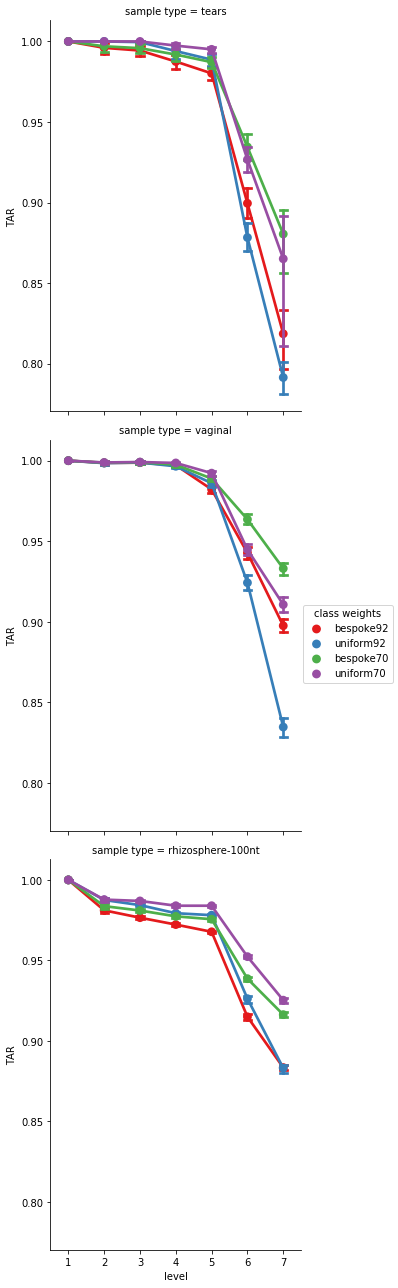

In [17]:
g = sns.factorplot(x="level", y="TAR", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


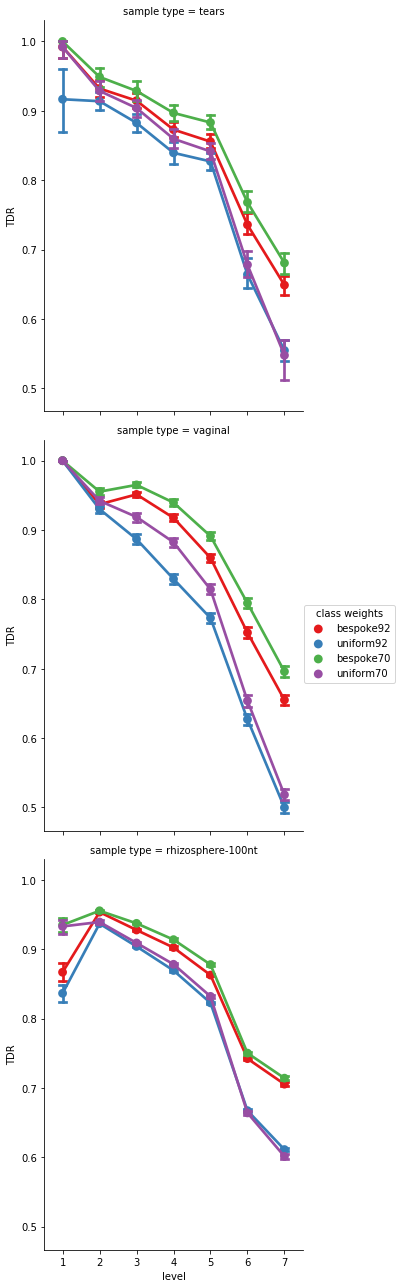

In [18]:
g = sns.factorplot(x="level", y="TDR", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


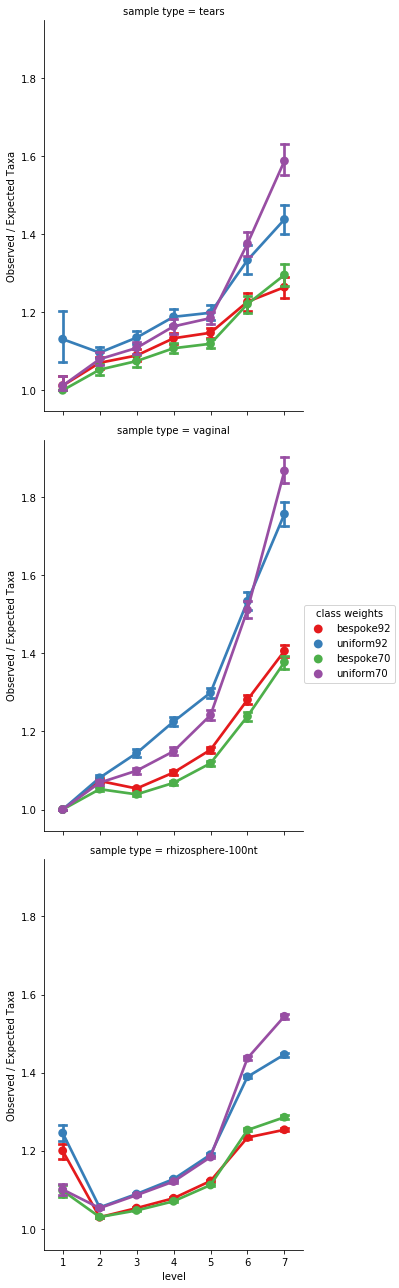

In [19]:
g = sns.factorplot(x="level", y="Observed / Expected Taxa", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


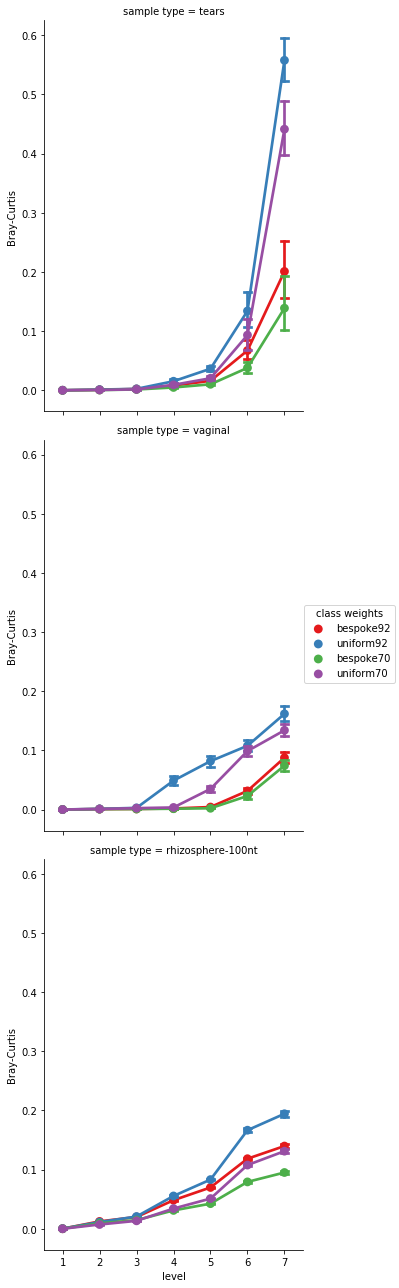

In [20]:
g = sns.factorplot(x="level", y="Bray-Curtis", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


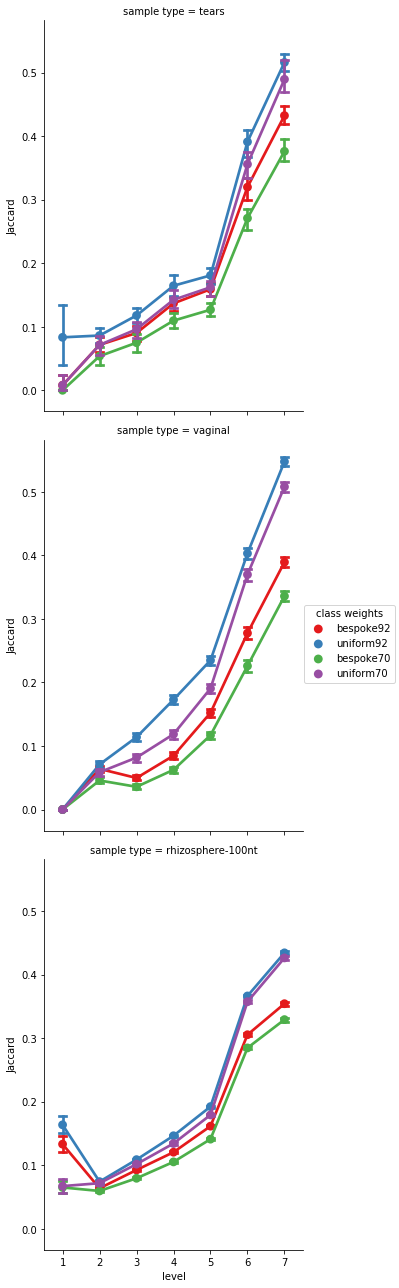

In [21]:
g = sns.factorplot(x="level", y="Jaccard", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)


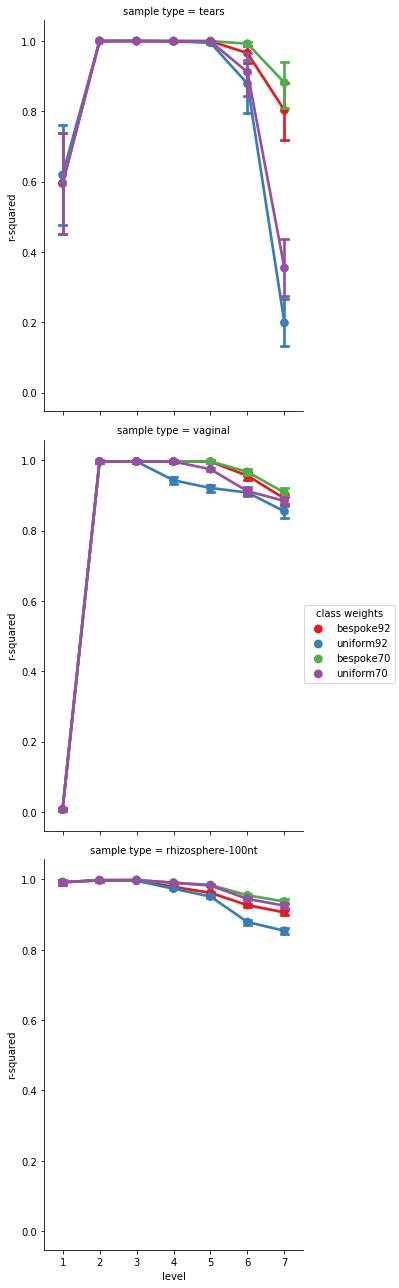

In [22]:
g = sns.factorplot(x="level", y="r-squared", hue="class weights", row="sample type", data=eval_comp_results,
                   capsize=.2, palette=palette, size=6, aspect=.75)
